### Logistic regression modeling
In this file, Logistic regression model is fit with the entire dataset containing significant indicator variables. The features are standardized in order to optimize the convergence of the algorithm and the predicted probabilities are calibrated using Isotonic Regression.
1. Import the imputed training set and validation set
2. Standardize each X matrix in order for the cost function to converge.
3. Adjust class weights to balance the classes and fit logistic regression models
4. Compare thresholds and models with fbeta score, recall, and precision

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from ipynb.fs.full.helper_functions import * # Custom function to create dummy variables
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import precision_recall_fscore_support, f1_score, accuracy_score, roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Make better use of Jupyter Notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#### 1. Import the imputed training set and validation set

In [2]:
X_train, X_val, y_train, y_val = pd.read_pickle('data/imp_train.pkl'), pd.read_pickle('data/imp_val.pkl'), pd.read_pickle('data/y_train.pkl'), pd.read_pickle('data/y_val.pkl')

#### 2. Standardize the three training sets in order for cost function to converge

In [3]:
scaler = StandardScaler().fit(X_train)
std_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)

std_val = \
pd.DataFrame(scaler.transform(X_val), columns = X_val.columns)

#### 3. Adjust the class weights and fit a logistic regression model

Non-Convergence is probably due to multicollinearity (even with max_iter = 1000)

In [4]:
lr = LogisticRegression(class_weight={0 : 1, 1 : 27}, solver='saga', penalty = 'l1', C = 0.01)
lr.fit(std_train, y_train);

/Users/jungakim/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


#### 4. Compare thresholds and models with fbeta score, recall, and precision

#### Training performance vs. Validation performance

Since the algorithm did not converge, coefficients are pretty biased which leads to less variance as well. Logistic Regression is the least overfit compared to the tree models.

Best Fbeta(1.5) score  0.42319 at prob decision threshold >=  0.74820


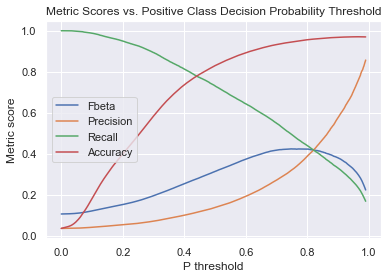

In [5]:
precs, recs, fbetas, acc_scores = plot_fbeta_recall_precision_acc(lr.predict_proba(std_train)[:,1], actual_y = y_train)

Best Fbeta(1.5) score  0.40694 at prob decision threshold >=  0.73829


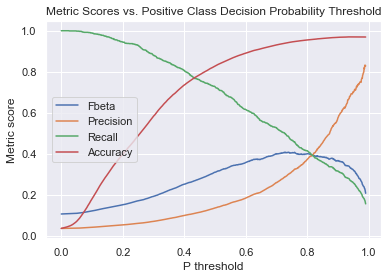

In [6]:
precs, recs, fbetas, acc_scores = plot_fbeta_recall_precision_acc(lr.predict_proba(std_val)[:,1], actual_y = y_val)

#### Checking calibration of the model within the training set

In [7]:
lr = pd.read_pickle('logistic_regression/lr.pkl')

In [8]:
pred_probs = lr.predict_proba(std_train)[:,1]
prob_true_uncalibrated, prob_pred_uncalibrated = calibration_curve(y_train, pred_probs, n_bins = 100)

Probabilities are extremely over-forecast

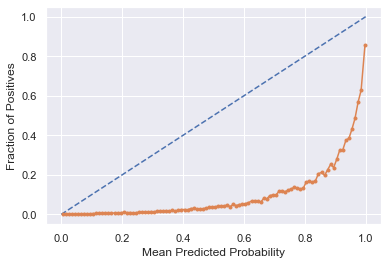

In [9]:
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(prob_pred_uncalibrated, prob_true_uncalibrated, marker='.')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives");

Apply Platt Scaling to the predicted probabilities with 10-fold cross validation.<br>
link: https://scikit-learn.org/stable/modules/calibration.html#calibration<br>
"*CalibratedClassifierCV uses a cross-validation approach to fit both the classifier and the regressor. For each of the k (trainset, testset) couple, a classifier is trained on the train set, and its predictions on the test set are used to fit a regressor. We end up with k (classifier, regressor) couples where each regressor maps the output of its corresponding classifier into [0, 1]. Each couple is exposed in the calibrated_classifiers_ attribute, where each entry is a calibrated classifier with a predict_proba method that outputs calibrated probabilities. The output of predict_proba for the main CalibratedClassifierCV instance corresponds to the average of the predicted probabilities of the k estimators in the calibrated_classifiers_ list. The output of predict is the class that has the highest probability.*"

In [10]:
model = LogisticRegression(class_weight={0 : 1, 1 : 27}, solver='saga', penalty = 'l1', C= 0.01)
calibrator_sigmoid = CalibratedClassifierCV(model, cv=10, method = 'sigmoid')
calibrator_sigmoid.fit(std_train, y_train)
pred_probs_sigmoid = calibrator_sigmoid.predict_proba(std_train)[:, 1]
prob_true_sigmoid, prob_pred_sigmoid = calibration_curve(y_train, pred_probs_sigmoid, n_bins = 100)

Apply Isotonic scaling to the predicted probabilities with 10-fold cross validation. 
link: https://scikit-learn.org/stable/modules/isotonic.html#isotonic<br>
"*It will fit a non-parametric isotonic regressor, which outputs a step-wise non-decreasing function.*"

In [11]:
calibrator_isotonic = CalibratedClassifierCV(model, cv=10, method = 'isotonic')
calibrator_isotonic.fit(std_train, y_train)
pred_probs_isotonic = calibrator_isotonic.predict_proba(std_train)[:, 1]
prob_true_isotonic, prob_pred_isotonic = calibration_curve(y_train, pred_probs_isotonic, n_bins = 100)

Calibrated with Platt scaling(sigmoid) is much more aligned with true probabilities than the uncalibrated.

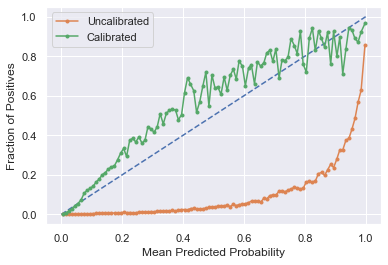

In [12]:
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(prob_pred_uncalibrated, prob_true_uncalibrated, marker='.', label = 'Uncalibrated')
plt.plot(prob_pred_sigmoid, prob_true_sigmoid, marker='.', label = 'Calibrated')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend();

Calibrated with Isotonic scaling is even more aligned with true probabilities.

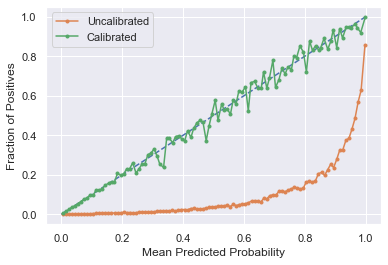

In [13]:
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(prob_pred_uncalibrated, prob_true_uncalibrated, marker='.', label = 'Uncalibrated')
plt.plot(prob_pred_isotonic, prob_true_isotonic, marker='.', label = 'Calibrated')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend();

Precision-Recall curve for calibrator of sigmoid function

Best Fbeta(1.5) score  0.42321 at prob decision threshold >=  0.08622


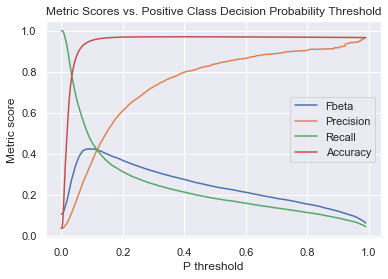

In [14]:
plot_fbeta_recall_precision_acc(calibrator_sigmoid.predict_proba(std_train)[:,1], actual_y = y_train)

Best Fbeta(1.5) score  0.40702 at prob decision threshold >=  0.08126


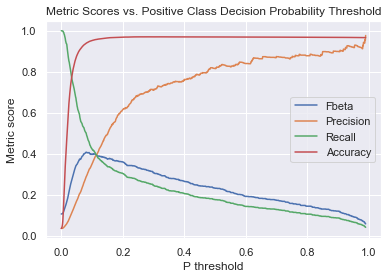

In [15]:
plot_fbeta_recall_precision_acc(calibrator_sigmoid.predict_proba(std_val)[:,1], actual_y = y_val)

Best Fbeta(1.5) score  0.42309 at prob decision threshold >=  0.14072


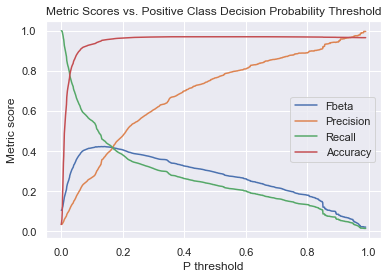

In [16]:
plot_fbeta_recall_precision_acc(calibrator_isotonic.predict_proba(std_train)[:,1], actual_y = y_train)

Best Fbeta(1.5) score  0.40642 at prob decision threshold >=  0.11396


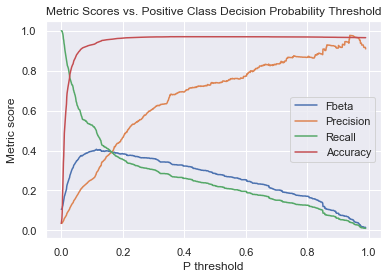

In [17]:
plot_fbeta_recall_precision_acc(calibrator_isotonic.predict_proba(std_val)[:,1], actual_y = y_val)

#### Final Model

Model hyperparameters

In [18]:
calibrator_isotonic

CalibratedClassifierCV(base_estimator=LogisticRegression(C=0.01,
                                                         class_weight={0: 1,
                                                                       1: 27},
                                                         penalty='l1',
                                                         solver='saga'),
                       cv=10, method='isotonic')

Cut-off probability to determine "Fraud" based on the results from isotonic calibrator

In [19]:
threshold = 0.11396

Final results: F_{1.5} = 0.40 with precision = 0.28 and recall = 0.50

In [20]:
pred_train = (calibrator_isotonic.predict_proba(std_train)[:, 1] >= threshold).astype(int)
prec, rec, fbeta, _ = precision_recall_fscore_support(y_train, pred_train , beta = 1.5, average = 'binary')
print(f"Train set: Precision = {round(prec, 5)}, Recall = {round(rec, 5)}, F_1.5 = {round(fbeta, 5)}")

pred_val = (calibrator_isotonic.predict_proba(std_val)[:, 1] >= threshold).astype(int)
prec, rec, fbeta, _ = precision_recall_fscore_support(y_val, pred_val, beta = 1.5, average = 'binary')
print(f"Val set: Precision = {round(prec, 5)}, Recall = {round(rec, 5)}, F_1.5 = {round(fbeta, 5)}\n")

Train set: Precision = 0.29469, Recall = 0.52137, F_1.5 = 0.42159
Val set: Precision = 0.28367, Recall = 0.49952, F_1.5 = 0.40475

